# **Privacy vs Utility Tradeoff**

In [ ]:
!pip install imblearn

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to load data and preprocess
def load_and_preprocess(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = [name.replace('[', '').replace(']', '').replace('<', '') for name in df.columns]
    df.columns = df.columns.map(str)  # Ensure column names are strings
    X = df.drop('Viral_sinusitis_present', axis=1)
    y = df['Viral_sinusitis_present']
    return X, y

# Provided list of continuous columns
continuous_columns = [
    'careplan_length', 'Diastolic Blood Pressure', 'Systolic Blood Pressure',
    'Body Mass Index', 'Total Cholesterol', 'High Density Lipoprotein Cholesterol',
    'Triglycerides', 'Low Density Lipoprotein Cholesterol', 'Glucose',
    'Hemoglobin A1c/Hemoglobin.total in Blood', 'Sodium', 'Chloride',
    'Potassium', 'Carbon Dioxide', 'Calcium', 'Urea Nitrogen',
    'Estimated Glomerular Filtration Rate']

def add_laplace_noise_continuous(data, column, epsilon, sensitivity):
    scale = sensitivity / epsilon
    noise = np.random.laplace(0, scale, size=len(data))
    noisy_column = data[column] + noise
    # Ensure values remain non-negative
    noisy_column = np.clip(noisy_column, 0, None)
    return noisy_column

def flip_binary_values(data, column, flip_probability):
    flip_mask = np.random.rand(len(data)) < flip_probability
    # XOR operation to flip the binary values and maintain them as integers
    return data[column].astype(int) ^ flip_mask.astype(int)

def add_noise_to_dataset(data, continuous_cols, feature_importances, base_epsilon=1.0, sensitivity=1.0):
    noisy_data = data.copy()

    # Normalize feature importances to sum to 1 if not already
    total_importance = sum(feature_importances.values())
    normalized_importances = {k: v / total_importance for k, v in feature_importances.items()}

    # Apply noise to continuous columns
    for column in continuous_cols:
        column_epsilon = base_epsilon / (normalized_importances.get(column, 1) + 1e-12)
        noisy_data[column] = add_laplace_noise_continuous(noisy_data, column, column_epsilon, sensitivity)

    # Determine binary columns and apply noise
    binary_columns = [col for col in data.columns if col not in continuous_cols]
    for column in binary_columns:
        column_epsilon = base_epsilon / (normalized_importances.get(column, 1) + 1e-12)
        flip_probability = min(sensitivity / column_epsilon, 1)
        noisy_data[column] = flip_binary_values(noisy_data, column, flip_probability)

    return noisy_data

# Function to evaluate the model (AUC score only)
def evaluate_model_auc(model, X_test, y_test):
    y_score = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_score)

# Load and preprocess the real test dataset
real_test_path = 'real_test.csv'  # Update paths if necessary
X_test_real, y_test_real = load_and_preprocess(real_test_path)

# Define the range of epsilon values to explore
epsilon_values = np.linspace(0.1, 2, num=10)  # Example range, adjust as needed

# Placeholder for feature importances
# Feature importance placeholder (paste your list here)
feature_importances = {
    "Amoxicillin 250 MG / Clavulanate 125 MG [Augmentin]": 0.6070259934088039,
    "careplan_within_24": 0.20196921117810945,
    "careplan_length": 0.0387404832992168,
    "Diastolic Blood Pressure": 0.01593174528114472,
    "Triglycerides": 0.013285744643897259,
    "Low Density Lipoprotein Cholesterol": 0.011156745043195106,
    "Systolic Blood Pressure": 0.011067519087524449,
    "Total Cholesterol": 0.010531923316692417,
    "Glucose": 0.01042754906238533,
    "encounter_type_emergency room visit": 0.009333681325762986,
    "Body Mass Index": 0.008730519405456768,
    "High Density Lipoprotein Cholesterol": 0.007936415133410847,
    "Throat culture (procedure)": 0.006606263992270559,
    "Hemoglobin A1c/Hemoglobin.total in Blood": 0.006303760356980994,
    "encounter_type_inpatient": 0.005856087719265674,
    "Documentation of current medications": 0.005441269840608777,
    "Chloride": 0.004144733624870049,
    "Urea Nitrogen": 0.003576803137127369,
    "Carbon Dioxide": 0.003048204013348675,
    "Sodium": 0.002693111108425654,
    "Estimated Glomerular Filtration Rate": 0.0023907123321869057,
    "Measurement of respiratory function (procedure)": 0.0016928165228212457,
    "Acetaminophen 160 MG": 0.0013037144637531137,
    "Potassium": 0.0005872619777878974,
    "Pneumococcal conjugate PCV 13": 0.0005684080815809761,
    "Sputum examination (procedure)": 0.0005661014176933233,
    "Naproxen sodium 220 MG Oral Tablet": 0.0005284994623340063,
    "ETHNICITY_chinese": 0.0004971493343409692,
    "ETHNICITY_asian_indian": 0.0004751397604113708,
    "Dextromethorphan Hydrobromide 1 MG/ML": 0.0004611668432281288,
    "ETHNICITY_french": 0.0004422913826401808,
    "ETHNICITY_swedish": 0.00042388640184692103,
    "Calcium": 0.0004238019239992515,
    "ETHNICITY_puerto_rican": 0.00041704896670753937,
    "MARITAL_M": 0.00038786427857969775,
    "ETHNICITY_polish": 0.0003798651072036011,
    "encounter_type_outpatient": 0.0003796169885940584,
    "ETHNICITY_portuguese": 0.0003542206478322841,
    "RACE_black": 0.0003468532065781131,
    "ETHNICITY_central_american": 0.00033266131592813944,
    "RACE_white": 0.00031254024599374787,
    "MARITAL_S": 0.00030616752730520973,
    "ETHNICITY_russian": 0.0002703578673445152,
    "ETHNICITY_mexican": 0.00026747319126676084,
    "ETHNICITY_french_canadian": 0.0002667909952212075,
    "RACE_asian": 0.00025457117005489165,
    "ETHNICITY_german": 0.00022120260498054584,
    "GENDER_F": 0.0002197621675960548,
    "ETHNICITY_irish": 0.00020553964689645247,
    "ETHNICITY_american": 0.00018853587082225104,
    "GENDER_M": 0.0001804390513286463,
    "ETHNICITY_scottish": 0.0001423932783752203,
    "ETHNICITY_west_indian": 0.00011673897235512194,
"Ibuprofen 200 MG Oral Tablet": 0.00010885407904905236,
"ETHNICITY_english": 7.310565550174923e-05,
"ETHNICITY_dominican": 7.095201838538164e-05,
"RACE_hispanic": 2.7731262977638095e-05,
"Spirometry (procedure)": 0.0,
"ETHNICITY_italian": 0.0,
"RACE_native": 0.0,
"varicella": 0.0,
"ETHNICITY_american_indian": 0.0,
"DTaP": 0.0,
"MMR": 0.0,
"ETHNICITY_african": 0.0
}

# Function to preprocess column names
def preprocess_column_names(name):
    return name.replace('[', '').replace(']', '').replace('<', '').replace(' ', '_')

# Apply the same preprocessing to the keys of the feature_importances dictionary
feature_importances = {preprocess_column_names(k): v for k, v in feature_importances.items()}

# Ensure no feature importance is zero to avoid division by zero in epsilon adjustment
feature_importances = {k: (v if v != 0 else 2.7731262977638095e-05) for k, v in feature_importances.items()}


# Dictionary to store the ROC AUC scores for each epsilon
roc_auc_scores = {}

# Initialize SMOTE for balancing
smote = SMOTE()

# Loop through different levels of noise (privacy)
for epsilon in epsilon_values:
    # Load and preprocess the synthetic dataset
    synthetic_data_path = 'synthetic_CTGAN_real_train1.csv'  # Update paths if necessary
    X_synthetic, y_synthetic = load_and_preprocess(synthetic_data_path)

    # Apply SMOTE to balance the synthetic dataset
    X_synthetic_smote, y_synthetic_smote = smote.fit_resample(X_synthetic, y_synthetic)

    # Add adaptive noise to the synthetic dataset
    noisy_X_synthetic = add_noise_to_dataset(X_synthetic_smote, continuous_columns, feature_importances, base_epsilon=epsilon)

    # Train the Logistic Regression model on the noisy, balanced synthetic data
    lr_model = LogisticRegression(max_iter=10000)
    lr_model.fit(noisy_X_synthetic, y_synthetic_smote)

    # Evaluate the model on the real test data and calculate ROC AUC
    auc_score = evaluate_model_auc(lr_model, X_test_real, y_test_real)
    roc_auc_scores[epsilon] = auc_score


# Plot the trade-off graph
plt.figure(figsize=(10, 6))
plt.plot(list(roc_auc_scores.keys()), list(roc_auc_scores.values()), marker='o')
plt.xlabel('Privacy Level (epsilon)')
plt.ylabel('Predictive Performance (ROC AUC)')
plt.title('Privacy vs. Predictive Performance Trade-off for CTGAN Synthetic Data')
plt.grid(True)
plt.show()


In [ ]:
print(epsilon_values)


[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [ ]:
print(roc_auc_scores)

{0.1: 0.440423314524939, 0.2: 0.4402480421678584, 0.30000000000000004: 0.48619967941468795, 0.4: 0.500678299587122, 0.5: 0.5118995000032028, 0.6: 0.517940729659266, 0.7000000000000001: 0.5287732708916322, 0.8: 0.5269625748923458, 0.9: 0.5287618390145328, 1.0: 0.5341651255806481}


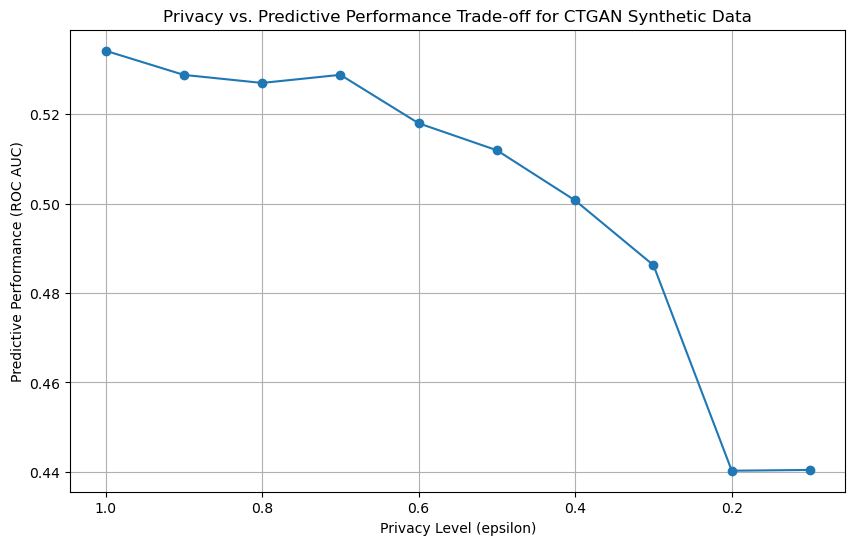

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(list(roc_auc_scores.keys()), list(roc_auc_scores.values()), marker='o')
plt.gca().invert_xaxis()  # This line inverts the x-axis
plt.xlabel('Privacy Level (epsilon)')
plt.ylabel('Predictive Performance (ROC AUC)')
plt.title('Privacy vs. Predictive Performance Trade-off for CTGAN Synthetic Data')
plt.grid(True)
plt.show()